# Candidate Recommendation System
****

# Importing the Libraries
****

In [476]:
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from pmdarima.arima import auto_arima
import xgboost as xgb
from tensorflow import keras
import lightgbm as lgb
import itertools 
import calendar
import glob
import os

In [477]:
pd.set_option('display.max_columns', None)
sn.set_palette("rocket")

# Get the data
****

## Importing The Data
****

Connecting to the API as the data source.

In [478]:
path = r'/Users/anastazijaverovic/Desktop/Candidate_Recommendation_System'
all_files = glob.glob(os.path.join(path, "*.csv"))

X_train = pd.concat((pd.read_csv(f) for f in all_files))

## Candidate selected - input

candidate_selected_id global variable should be taken from the code above, using the selected user on the website. This example is just fixated in order to test the model.

In [479]:
candidate_selected_id = "WZKVV2ikfnr1V7SjDBW0iA_0000"

## Data Format Converting
****

Changing the file type if needed

In [480]:
#X_train = pd.read_csv('X_train.tsv', delimiter='\t', decimal=",")
#X_train.to_csv("X_train_csv.csv", sep=',', encoding='utf-8', quotechar='"', decimal='.')

# Looking Into The Data
****

In [481]:
X_train.describe()

,birth_year,linkedin_id,facebook_id,mobile_phone,job_company_founded,job_company_linkedin_id,job_company_location_postal_code,location_postal_code,phone_numbers/0,experience/0/company/linkedin_id,experience/1/company/location,experience/1/company/linkedin_id,experience/2/company/linkedin_id,experience/3/company/linkedin_id,experience/4/company/linkedin_id,education/0/school/linkedin_id,education/0/gpa,education/1/school/location,education/1/school/linkedin_id,education/1/gpa,education/2/school/linkedin_id,education/2/gpa,education/3/school/location,education/3/school/linkedin_id,education/3/gpa,education/4/school/linkedin_id,education/4/gpa,education/5/school/linkedin_id,education/5/end_date,education/5/gpa,education/6/school/location,education/6/school/linkedin_id,education/6/end_date,education/6/gpa,profiles/0/id,profiles/1/id,version_status/previous_version,version_status/current_version,experience/5/company/founded,experience/5/company/linkedin_id,experience/6/company/founded,experience/6/company/linkedin_id,education/2/school/location,profiles/2/id,profiles/3/id,profiles/4/id,education/0/school/location,education/4/school/location,education/5/school,experience/2/company/location,profiles/5/id,street_addresses/0/postal_code,education/1/school,education/5/school/location,education/7/school,education/7/end_date,education/7/start_date,education/7/gpa,education/8/school/location,education/8/school/linkedin_id,education/8/end_date,education/8/start_date,education/8/gpa,education/9/school/linkedin_id,education/9/start_date,education/9/gpa,education/10/school/location,education/10/school/linkedin_id,education/10/end_date,education/10/start_date,education/10/gpa,experience/7/company/founded,experience/7/company/linkedin_id,experience/8/company/founded,experience/8/company/linkedin_id,experience/9/company/founded,experience/9/company/linkedin_id,experience/10/company/founded,experience/10/company/linkedin_id,education/7/school/linkedin_id,experience/0/company/location,experience/4/company/location,experience/9/company/location,experience/3/company/location,phone_numbers/1,street_addresses/1/postal_code,profiles/6/id,profiles/7/id,profiles/8/id,profiles/9/id,profiles/10/id,education/7/school/location,experience/6/company/location,experience/8/company/location,education/2/school,experience/11/company/founded,experience/11/company/location/postal_code,experience/11/company/linkedin_id,experience/12/company/founded,experience/12/company/location/postal_code,experience/12/company/linkedin_id,education/0/school,education/3/school,experience/11/company/location,experience/13/company/founded,experience/13/company/location/postal_code,experience/13/company/linkedin_id,experience/14/company/founded,experience/14/company/location/postal_code,experience/14/company/linkedin_id,street_addresses/2/postal_code,street_addresses/3/postal_code,street_addresses/4/postal_code,street_addresses/5/postal_code,street_addresses/6/postal_code,street_addresses/7/postal_code,street_addresses/8/postal_code,street_addresses/9/postal_code,experience/7/company/location,experience/5/company/location,education/8/school,phone_numbers/2,education/4/school,experience/0/company,experience/10/company/location,phone_numbers/3,experience/15/company/founded,experience/15/company/location/postal_code,experience/15/company/linkedin_id,phone_numbers/4,phone_numbers/5,phone_numbers/6,phone_numbers/7,phone_numbers/8,phone_numbers/9,phone_numbers/10,phone_numbers/11,phone_numbers/12,street_addresses/10/postal_code,street_addresses/11/postal_code,street_addresses/12/postal_code,street_addresses/13/postal_code,street_addresses/14/postal_code,street_addresses/15/postal_code,experience/16/company/founded,experience/16/company/location/postal_code,experience/16/company/linkedin_id,experience/17/company/founded,experience/17/company/location/street_address,experience/17/company/location/address_line_2,experience/17/company/location/postal_code,experience/17/company/linkedin_id,experien

# Dealing with Missing Values
****

In [482]:
def missing_data_percentage(column):
    percentage = (X_train[column].isna().sum()/len(X_train[column])) * 100
    #print('{} column - missing data percentage: {:.2f} %' .format(column, percentage))
    return float(percentage)

The columns with more than 50% of missing values will be removed from the dataset:

In [483]:
for column in X_train.columns:
    percentage = missing_data_percentage(column)
    if percentage > 50:
        X_train = X_train.drop(column, axis = 1)

Dealing with missing data - using median value for continuos data and mode for categorical data

In [484]:
def fill_na(column):
    if column.isnumeric():
        print(X_train[column])
        X_train[column].fillna(X_train[column].median(), inplace=True)
    else:
        X_train[column].fillna(X_train[column].mode()[0], inplace=True)

In [485]:
for column in X_train.columns:
    fill_na(column)
    percentage = missing_data_percentage(column)
    #print(percentage)

# Data Outliers
****

The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles.
It is represented by the formula IQR = Q3 − Q1.
The lines of code below calculate and print the interquartile range for each of the variables in the dataset

In [486]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_columns = X_train.select_dtypes(include = numerics)
columns = num_columns.columns

Q1 = X_train[columns].quantile(0.25)
Q3 = X_train[columns].quantile(0.75)
IQR = Q3 - Q1

Removing the outliers and calculating the skewness value again:

In [487]:
def transform_columns_flooring_capping(dataset, column):
    #print("Skewness of column {} BEFORE the flooring and capping: {:.2f}".format(column, dataset[column].skew()))
    
    dataset[column] = np.where(dataset[column] < dataset[column].quantile(0.10), dataset[column].quantile(0.10), dataset[column])
    dataset[column] = np.where(dataset[column] > dataset[column].quantile(0.90), dataset[column].quantile(0.90), dataset[column])
    
    #print("Skewness of column {} AFTER the flooring and capping: {:.2f}\n".format(column, dataset[column].skew()))
    return dataset[column]

In [488]:
for column in columns:
    transform_columns_flooring_capping(X_train, column)

It is visible that removing the outliers below the 10th quantile and above 90th quantile results in better skewness of every column.

# Data Transformations
****

In [489]:
len(X_train.columns)

237

In [490]:
X_train.infer_objects()
X_train.dtypes

id                                       object
full_name                                object
first_name                               object
last_initial                             object
last_name                                object
                                          ...  
education/1/school/location/country      object
education/1/school/location/continent    object
profiles/2/network                       object
profiles/2/url                           object
profiles/2/username                      object
Length: 237, dtype: object

There is a problem with columns named size, because some of them instead of the size in numbers (i.e. 1-10) have the 01 Oct.

In [491]:
for column in X_train.columns:
    if 'size' in column:
        X_train[column] = X_train[column].astype("string")

Removing other columns not significant for the similarity score and personal information (GDPR) data (name/middle name/surname/email/...) since only id column will be enough to return to get the information on the person

In [492]:
substrings = [
            'phone_numbers',
            'website', 'facebook', 'twitter',
            'email', 'school/name', 'continent', 'company/id', 'school/id', 'is_primary',
            'company/name', 'location/geo', 'postal_code', 'gender', 'version_status', 'metro',
            'street', 'url', 'job_company_id',
            'start_date', 'end_date', 'profiles',
    'linkedin_username', 'linkedin_id', 'job_company_linkedin_id',
    'job_company_location_geo', 'job_last_updated', 'interests', 'founded', 'domain',
    'location_geo','location_last_updated'
             ]

to_drop = []

for column in X_train.columns:
    for substring in substrings:
        if (substring in column):
            to_drop.append(column)

X_train = X_train.drop(to_drop, axis = 1)

In [493]:
X_train = X_train.drop(['full_name', 'first_name', 'last_name', 'mobile_phone', 'last_initial'] ,axis = 1)

# Attributes Correlation
****

Pearson’s correlation coefficient is the test statistics that measures the statistical relationship, or association, between two continuous variables.

When there are two independent variables that are very highly correlated, you definitely should remove one of them because you run into the multicollinearity conundrum and your regression model's coefficients related to the two highly correlated variables will be unreliable.

In [494]:
dataset = X_train # encoded X_train

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dataset = dataset.apply(le.fit_transform)
dataset.head(2)

,id,industry,job_title,job_title_levels/0,job_company_name,job_company_size,job_company_industry,job_company_location_name,job_company_location_locality,job_company_location_region,job_company_location_country,location_name,location_locality,location_region,location_country,skills/0,skills/1,skills/2,skills/3,skills/4,skills/5,skills/6,skills/7,skills/8,skills/9,skills/10,skills/11,skills/12,skills/13,skills/14,skills/15,skills/16,skills/17,skills/18,skills/19,skills/20,skills/21,skills/22,skills/23,skills/24,location_names/0,location_names/1,regions/0,countries/0,experience/0/company/size,experience/0/company/industry,experience/0/company/location/name,experience/0/company/location/locality,experience/0/company/location/region,experience/0/company/location/country,experience/0/title/name,experience/0/title/role,experience/0/title/levels/0,experience/1/company/size,experience/1/company/industry,experience/1/title/name,experience/1/title/role,experience/2/company/size,experience/2/company/industry,experience/2/company/location/name,experience/2/company/location/locality,experience/2/company/location/region,experience/2/company/location/country,experience/2/title/name,experience/2/title/levels/0,experience/3/company/size,experience/3/company/industry,experience/3/company/location/name,experience/3/company/location/locality,experience/3/company/location/region,experience/3/company/location/country,experience/3/title/name,experience/3/title/levels/0,experience/4/company/size,experience/4/company/industry,experience/4/company/location/name,experience/4/company/location/locality,experience/4/company/location/region,experience/4/company/location/country,experience/4/title/name,education/0/school/type,education/0/school/location/name,education/0/school/location/country,education/1/school/type,education/2/school/type,location_names/2,regions/1,experience/1/company/location/name,experience/1/company/location/locality,experience/1/company/location/region,experience/1/company/location/country,experience/1/title/levels/0,experience/5/company/size,experience/5/company/industry,experience/5/company/location/name,experience/5/company/location/country,experience/5/title/name,experience/6/company/size,experience/6/company/industry,experience/6/title/name,education/1/school/location/name,education/1/school/location/country
0,320,0,5,3,234,1,49,34,30,70,10,144,139,66,2,20,110,143,123,108,103,15,127,285,3,301,24,278,105,98,299,121,49,145,114,117,60,99,227,184,30,138,85,11,1,45,27,24,57,8,378,13,9,1,46,377,13,1,57,132,115,64,26,94,1,1,58,113,102,29,26,296,2,1,48,114,93,61,27,287,0,73,14,0,0,105,40,145,105,77,28,3,1,36,107,26,42,1,38,35,149,29
1,136,91,5,3,13,3,92,35,31,74,24,144,139,66,2,101,281,38,170,229,161,26,165,50,222,8,90,162,153,141,223,145,145,25,31,33,148,19,111,125,180,22,85,11,7,54,144,125,109,6,357,13,7,2,32,361,13,1,57,195,115,64,26,26,3,3,94,23,20,69,27,357,7,1,18,32,28,101,13,313,0,20,27,0,0,25,13,51,47,53,28,7,3,81,24,26,16,1,47,22,15,29


In [495]:
corr = dataset.corr()
corr

,id,industry,job_title,job_title_levels/0,job_company_name,job_company_size,job_company_industry,job_company_location_name,job_company_location_locality,job_company_location_region,job_company_location_country,location_name,location_locality,location_region,location_country,skills/0,skills/1,skills/2,skills/3,skills/4,skills/5,skills/6,skills/7,skills/8,skills/9,skills/10,skills/11,skills/12,skills/13,skills/14,skills/15,skills/16,skills/17,skills/18,skills/19,skills/20,skills/21,skills/22,skills/23,skills/24,location_names/0,location_names/1,regions/0,countries/0,experience/0/company/size,experience/0/company/industry,experience/0/company/location/name,experience/0/company/location/locality,experience/0/company/location/region,experience/0/company/location/country,experience/0/title/name,experience/0/title/role,experience/0/title/levels/0,experience/1/company/size,experience/1/company/industry,experience/1/title/name,experience/1/title/role,experience/2/company/size,experience/2/company/industry,experience/2/company/location/name,experience/2/company/location/locality,experience/2/company/location/region,experience/2/company/location/country,experience/2/title/name,experience/2/title/levels/0,experience/3/company/size,experience/3/company/industry,experience/3/company/location/name,experience/3/company/location/locality,experience/3/company/location/region,experience/3/company/location/country,experience/3/title/name,experience/3/title/levels/0,experience/4/company/size,experience/4/company/industry,experience/4/company/location/name,experience/4/company/location/locality,experience/4/company/location/region,experience/4/company/location/country,experience/4/title/name,education/0/school/type,education/0/school/location/name,education/0/school/location/country,education/1/school/type,education/2/school/type,location_names/2,regions/1,experience/1/company/location/name,experience/1/company/location/locality,experience/1/company/location/region,experience/1/company/location/country,experience/1/title/levels/0,experience/5/company/size,experience/5/company/industry,experience/5/company/location/name,experience/5/company/location/country,experience/5/title/name,experience/6/company/size,experience/6/company/industry,experience/6/title/name,education/1/school/location/name,education/1/school/location/country
id,1.000000,-0.050500,0.028631,0.024618,-0.017438,0.047169,0.024452,0.018378,0.009813,-0.048210,0.008988,-0.069299,-0.067112,-0.051486,-0.043080,0.010144,0.102648,0.004779,0.064614,0.073124,0.051524,-0.014649,-0.010934,0.030834,0.075696,-0.028078,0.014907,0.010140,0.003780,-0.069149,0.112458,-0.021734,0.026494,-0.046825,-0.012966,-0.031889,0.022813,-0.039418,0.026867,0.024176,-0.068871,-0.012320,-0.040154,-0.022308,-0.001062,0.044901,0.023588,0.026140,0.043947,0.048021,0.038581,0.085365,-0.057029,0.065249,-0.031443,-0.072736,0.017239,-0.023477,-0.035549,0.036422,0.044347,0.010864,-0.006116,0.004288,0.004910,-0.017236,0.046403,-0.033822,-0.020458,0.038445,-0.056028,-0.040920,-0.069486,-0.025829,-0.035615,-0.008208,-0.008861,-0.000389,-0.048282,0.117367,0.051792,-0.042821,-0.054025,-0.056975,0.036652,-0.030361,-0.026294,-0.068281,-0.058715,-0.023423,-0.030393,-0.076820,-0.020125,0.039075,-0.038189,-0.038596,0.088273,-0.044547,0.062945,-0.014753,-0.006663,-0.004950
industry,-0.050500,1.000000,-0.101469,-0.115636,0.100436,0.107995,0.631255,-0.056333,-0.059131,0.014480,0.003692,-0.005084,-0.008310,0.062414,0.020702,0.038264,0.019334,0.041928,0.015154,-0.014246,0.009371,-0.033544,0.065057,-0.033696,0.022595,0.065277,0.013047,-0.072211,-0.050912,-0.001849,-0.035137,-0.011842,0.011235,0.040647,0.070193,0.054743,-0.119305,0.073217,0.070051,-0.029593,-0.018585,0.063070,0.045504,-0.001645,0.088615,0.374817,0.034462,0.011072,0.000814,0.047281,-0.070476,-0.024137,-0.105702,0.126314,0.312857,-0.032958,0.009529,0.008198,0.246935,-0.001524,0.004436,-0.008980,0.054878,-0.009686,0.055930,0.048641,0.282814,-0.011154,-0.038151,-0.004478,0.032769,

Here we are taking only the upper triangle of the correlation matrix to remove only one highly correlated attribute (and to look only positive correlation (Pearson's coefficient ranges from -1 to 1)).

Generally, if the correlation between a pair of variables is greater than 0.5-0.6, we should seriously consider dropping one of those variables.
We are selecting the columns which are having absolute correlation greater than 0.8 and making a list of those columns named 'to_drop'.

pearson's r = correlation coefficient = r:

0.00-0.19: very weak
0.20-0.39: weak
0.40-0.59: moderate 
0.60-0.79: strong
0.80-1.00: very strong

In [496]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

<ipython-input-496-5563e36824c2>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))


In [497]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

['job_title_levels/0', 'job_company_location_locality', 'location_locality', 'experience/0/company/location/locality', 'experience/2/company/location/locality', 'experience/3/company/location/locality', 'experience/4/company/location/locality', 'experience/1/company/location/locality']


Using Pearson's Correlation Coefficient, there is a couple of  variables that are highly correlated (𝜌 > 0.75)

In [498]:
X_train = X_train.drop(to_drop, axis = 1)

Adding row number column:

In [499]:
X_train['row_num'] = X_train.reset_index().index

# Explorative Data Analysis
****

Visualizing the candidates information in the input dataset:

In [500]:
def plot(dataset, column):
    plt.subplots(figsize = (15,2))
    sn.countplot(x = dataset[column], hue = dataset[column])
    plt.show()

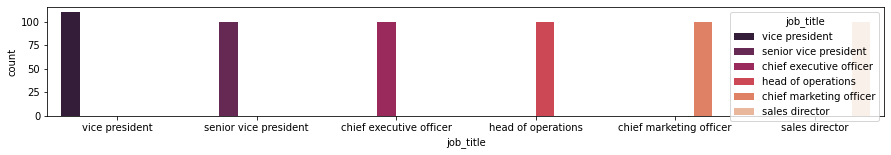

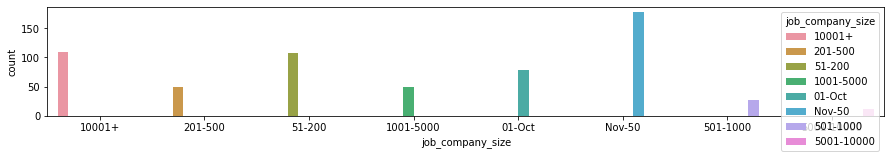

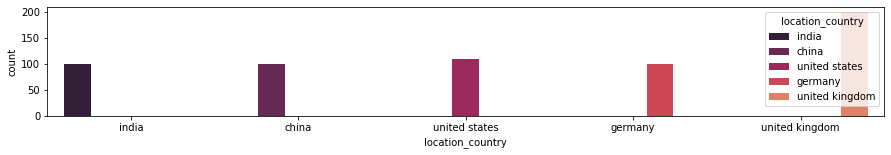

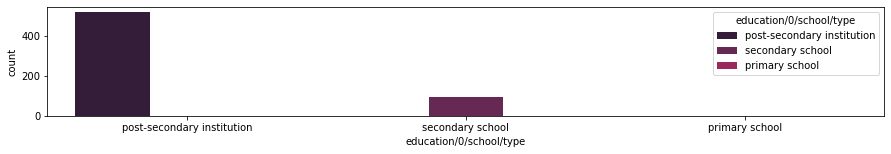

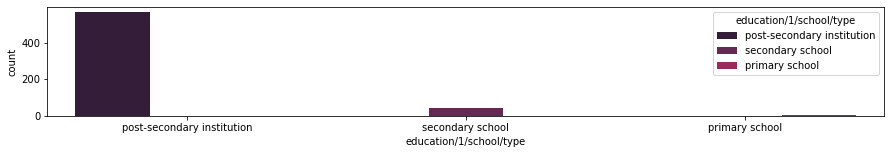

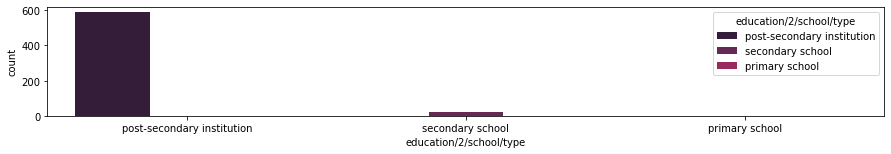

In [501]:
columns_to_visualize = ['job_title', 'job_company_size', 'location_country', 'education/0/school/type', 'education/1/school/type',
                       'education/2/school/type']

for column in columns_to_visualize:
    plot(X_train, column)

The graphs above show the **distribution** of the data by the labels:
* there is similar number of candidates by the current job title
* most candidates work in smaller companies (10-50 employees)
* similar number of candidates come from India, China, Germany, UK and US respectively
* Most candidates have post-secondary education institution (probably because rarely people reffer primary school as education on the job sites)

**Job industry types**

In [502]:
len(X_train["industry"].unique())

94

There are 94 industries, we will try and create less categories by identifying similar ones:

In [503]:
X_train["industry"] = X_train["industry"].replace(["computer software", "internet", 'computer & network security', 
                             'computer games','information services', 'computer networking'],
                            'information technology and services')

X_train["industry"] = X_train["industry"].replace(['education management', 'primary/secondary education', 'e-learning', 'higher education'], 
                            "education")

X_train["industry"] = X_train["industry"].replace(['staffing and recruiting'], 'human resources')


X_train["industry"] = X_train["industry"].replace(['broadcast media', 'media production', 'online media', 'publishing', 'telecommunications',
                                                  'entertainment', 'publishing'],
                                                  'media')


X_train["industry"] = X_train["industry"].replace(['venture capital & private equity',
                                                  'capital markets', 'investment management'], 
                                                  'investment and markets')

X_train["industry"] = X_train["industry"].replace(['banking'], 'financial services')

In [504]:
len(X_train["industry"].unique())

76

In [505]:
def plot_pie_chart_top_5(dataset, column):

    temp = dataset[column].value_counts()
    temp2 = temp.head(5)
    if len(temp) > 5:
        temp2['remaining {0} items'.format(len(temp) - 5)] = sum(temp[5:])

    temp2.plot(kind='pie')

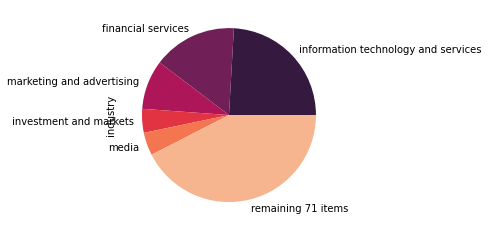

In [506]:
plot_pie_chart_top_5(X_train, "industry")

It is visible that the most common candidates' industry is IT, with financial services, marketing and investments close behind.

# Similarity Measure
****

Using jaccard similarity measure to get the similarity between the candidates - just to test it out. This part isn't used later on in the model making technique.

In [507]:
def compute_jaccard_similarity_score(x, y):
    """
    Jaccard Similarity J (A,B) = | Intersection (A,B) | /
                                    | Union (A,B) |
    """
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    return intersection_cardinality / float(union_cardinality)

In [508]:
def find_match(user_id):
    res_max = 0
    idx = 0
    for i in range(len(X_train)):
        if (i != user_id):
            res = compute_jaccard_similarity_score(X_train.iloc[user_id].values, X_train.iloc[i].values)
            if res > res_max:
                res_max = res
                idx = i        
    return X_train.iloc[(X_train.index == user_id) | (X_train.index == idx)]

In [509]:
find_match(8)

,id,industry,job_title,job_company_name,job_company_size,job_company_industry,job_company_location_name,job_company_location_region,job_company_location_country,location_name,location_region,location_country,skills/0,skills/1,skills/2,skills/3,skills/4,skills/5,skills/6,skills/7,skills/8,skills/9,skills/10,skills/11,skills/12,skills/13,skills/14,skills/15,skills/16,skills/17,skills/18,skills/19,skills/20,skills/21,skills/22,skills/23,skills/24,location_names/0,location_names/1,regions/0,countries/0,experience/0/company/size,experience/0/company/industry,experience/0/company/location/name,experience/0/company/location/region,experience/0/company/location/country,experience/0/title/name,experience/0/title/role,experience/0/title/levels/0,experience/1/company/size,experience/1/company/industry,experience/1/title/name,experience/1/title/role,experience/2/company/size,experience/2/company/industry,experience/2/company/location/name,experience/2/company/location/region,experience/2/company/location/country,experience/2/title/name,experience/2/title/levels/0,experience/3/company/size,experience/3/company/industry,experience/3/company/location/name,experience/3/company/location/region,experience/3/company/location/country,experience/3/title/name,experience/3/title/levels/0,experience/4/company/size,experience/4/company/industry,experience/4/company/location/name,experience/4/company/location/region,experience/4/company/location/country,experience/4/title/name,education/0/school/type,education/0/school/location/name,education/0/school/location/country,education/1/school/type,education/2/school/type,location_names/2,regions/1,experience/1/company/location/name,experience/1/company/location/region,experience/1/company/location/country,experience/1/title/levels/0,experience/5/company/size,experience/5/company/industry,experience/5/company/location/name,experience/5/company/location/country,experience/5/title/name,experience/6/company/size,experience/6/company/industry,experience/6/title/name,education/1/school/location/name,education/1/school/location/country,row_num
8,Kvynhok4bMiGDZrfHMrB8g_0000,financial services,vice president,citi,10001+,financial services,"new york, new york, united states",new york,united states,"mumbai, maharashtra, india",maharashtra,india,personnel management,recruiting,performance management,talent management,human resources,management,hris,team management,employee engagement,people skills,compensation and benefits,employee relations,deferred compensation,training,generalist hr,hr policies,talent acquisition,organizational development,human resources information systems,total rewards strategies,human relations,recruitment,business development,leadership,management,"bengaluru, karnataka, india","bombay, maharashtra, india","maharashtra, india",india,10001+,pharmaceuticals,india,new york,india,regional human resources,human_resources,director,10001+,food & beverages,human resources summer intern,human_resources,10001+,pharmaceuticals,"bombay, maharashtra, india",maharashtra,india,human resources intern,training,1001-5000,consumer goods,"bombay, maharashtra, india",maharashtra,india,human resources intern,training,5001-10000,information technology and services,"new york, new york, united states",new york,united states,human resources intern,post-secondary institution,united kingdom,united states,post-secondary institution,post-secondary institution,"mumbai, maharashtra, india","karnataka, india","vevey, vaud, switzerland",vaud,switzerland,training,10001+,oil & energy,"the hague, zuid-holland, netherlands",netherlands,human resources intern,501-1000,consumer goods,sales human resources business partner and c a...,united kingdom,united states,8
8,OFvBccCIoIKiaqKwTVA9PA_0000,information technology and services,senior vice president,心动网络 xindong network (xd.com),201-500,information technology and services,"shanghai, shanghai, china",shanghai,china,"shanghai, shanghai, china",shanghai,china,game development,video games,

In [510]:
compute_jaccard_similarity_score(X_train.iloc[8].values, X_train.iloc[77].values)

0.22826086956521738

# Creating the Model
****

## KModes clustering

KModes clustering is one of the unsupervised Machine Learning algorithms that is used to cluster categorical variables.

In [511]:
#X_train = X_train[X_train["id"] != candidate_selected_id]

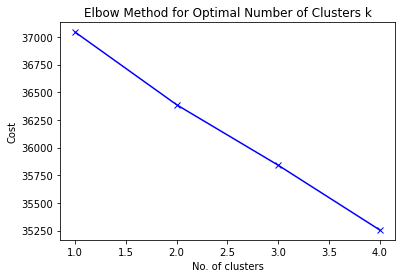

In [512]:
from kmodes.kmodes import KModes

cost = []
K = range(1,5)

for num_clusters in list(K):
    kmode = KModes(n_clusters = num_clusters, init = "random", n_init = 5, verbose = 0)
    kmode.fit_predict(X_train)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal Number of Clusters k')
plt.show()

KModes algorithm steps:

- Pick K observations at random and use them as leaders/clusters
- Calculate the dissimilarities and assign each observation to its closest cluster
- Define new modes for the clusters
- Repeat 2–3 steps until there are is no re-assignment required

KModes calculates all the dissimilarities and put them in a matrix and assigns the observations to their closest cluster(cluster that has the least dissimilarity)

Mode is simply the most observed value.

The difference between k-means and k-modes lies in the metric used for clustering. Where k-means uses a distance metric between two objects to cluster similar datapoints, k-modes utilizes the total number of mismatches between two objects. In other words, it uses a mode metric instead of a mean distance metric.

In [513]:
# Building the model with 3 clusters

kmode = KModes(n_clusters = 3, init = "random", n_init = 4, verbose = 1)
clusters = kmode.fit_predict(X_train)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 174, cost: 36138.0
Run 1, iteration: 2/100, moves: 34, cost: 36096.0
Run 1, iteration: 3/100, moves: 10, cost: 36093.0
Run 1, iteration: 4/100, moves: 3, cost: 36092.0
Run 1, iteration: 5/100, moves: 0, cost: 36092.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 194, cost: 36020.0
Run 2, iteration: 2/100, moves: 84, cost: 35993.0
Run 2, iteration: 3/100, moves: 27, cost: 35974.0
Run 2, iteration: 4/100, moves: 10, cost: 35971.0
Run 2, iteration: 5/100, moves: 0, cost: 35971.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 247, cost: 35851.0
Run 3, iteration: 2/100, moves: 56, cost: 35839.0
Run 3, iteration: 3/100, moves: 7, cost: 35836.0
Run 3, iteration: 4/100, moves: 5, cost: 35835.0
Run 3, iteration: 5/100, moves: 1, cost: 35835.0
Init: initial

In [514]:
print("Cluster 0 size: ", len(cluster_0))
print("Cluster 1 size: ", len(cluster_1))
print("Cluster 2 size: ", len(cluster_2))

Cluster 0 size:  372
Cluster 1 size:  167
Cluster 2 size:  70


In [515]:
X_train["Cluster"] = clusters

## Clusters Visualization

In [516]:
cluster_0 = X_train[X_train["Cluster"] == 0]
cluster_1 = X_train[X_train["Cluster"] == 1]
cluster_2 = X_train[X_train["Cluster"] == 2]

**Cluster 0**

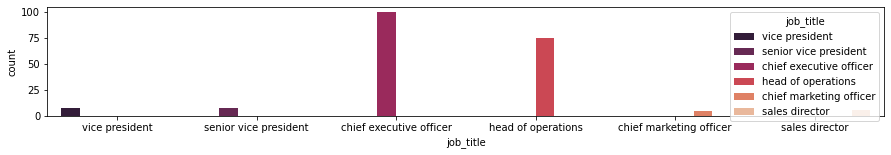

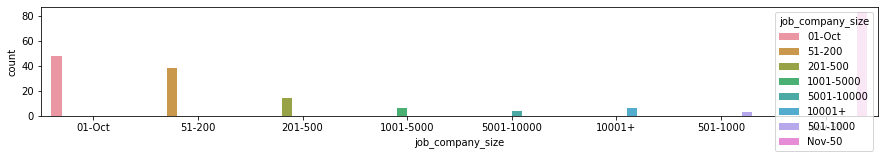

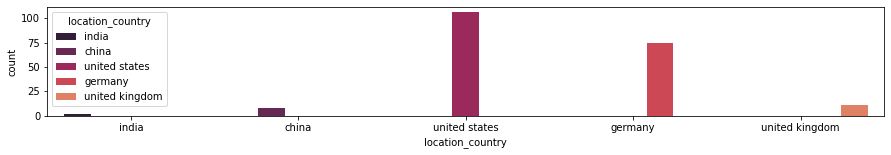

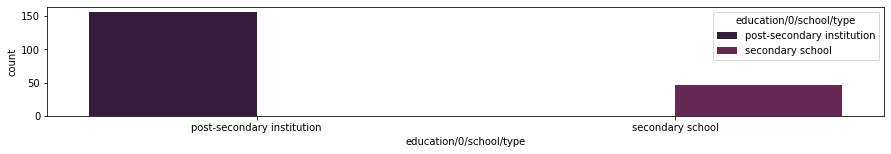

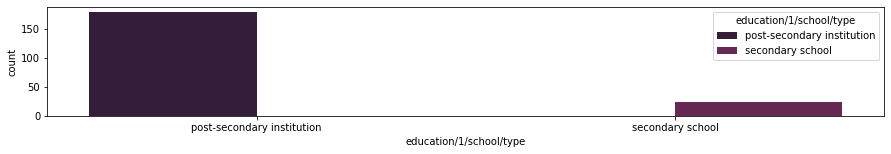

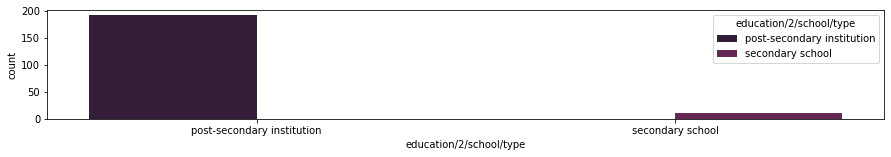

In [517]:
for column in columns_to_visualize:
    plot(cluster_0, column)

From the graphs above, it is visible that the cluster 0 is made of VPs, Senior VPs and CEOs mostly, working in companies sized 200-500 or 10000+ employees, from US, India and Chine mostly.

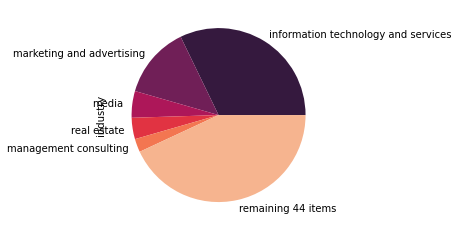

In [518]:
plot_pie_chart_top_5(cluster_0, "industry")

The pie chart shows that most of the candidates in the cluster 0 work in IT, secondly in marketing.

**Cluster 1**

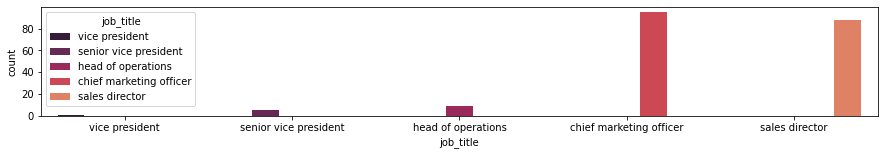

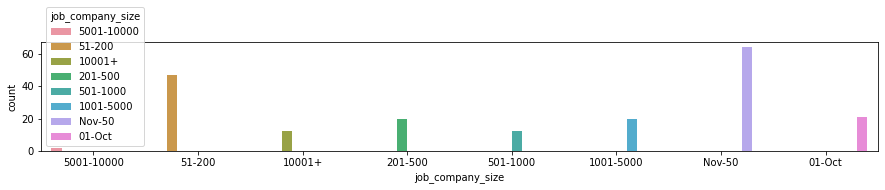

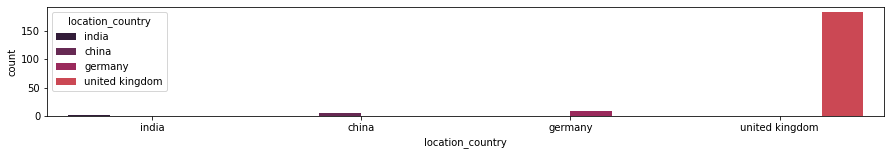

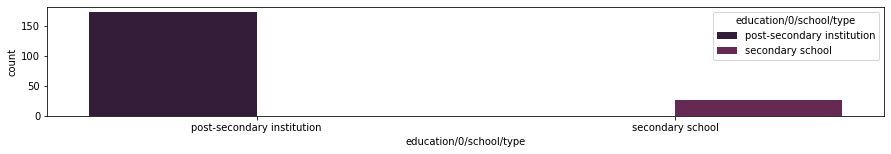

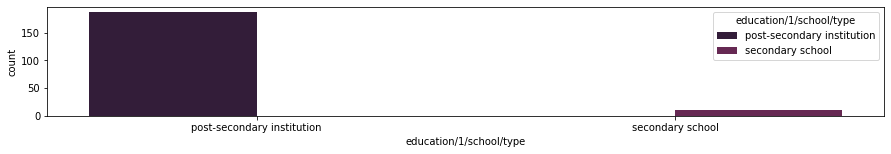

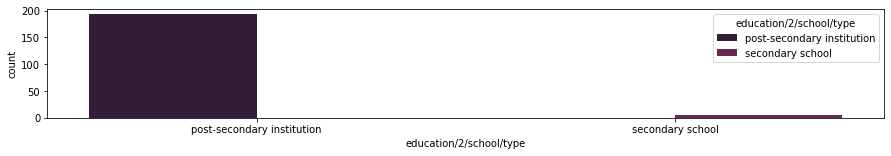

In [519]:
for column in columns_to_visualize:
    plot(cluster_1, column)

Cluster 1 consists mostly of candidates working as CMOs and sales directors in UK, with post-secondary education.

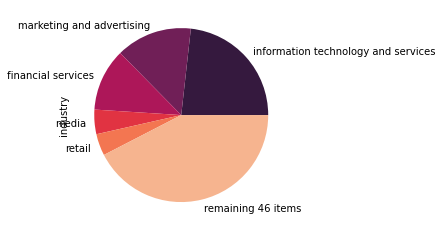

In [520]:
plot_pie_chart_top_5(cluster_1, "industry")

Most candidates in cluster 1 work in IT and marketing and advertising

**Cluster 2**

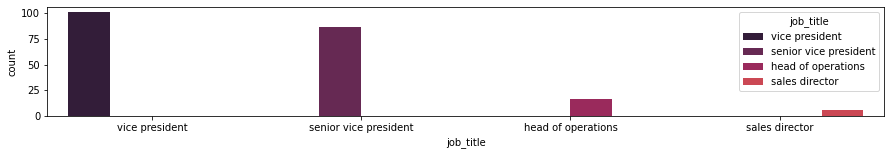

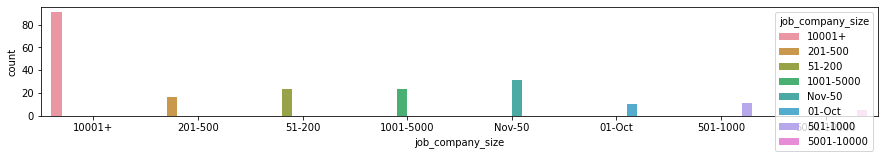

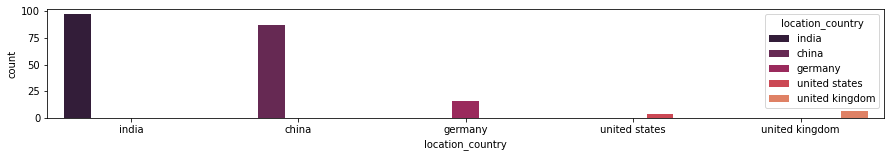

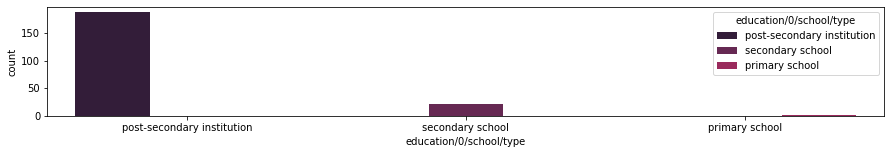

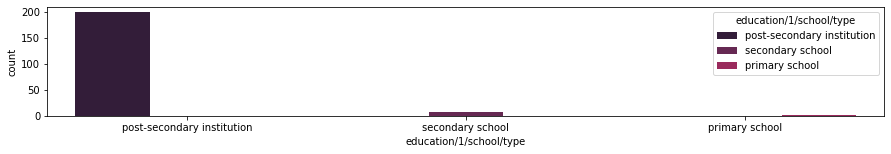

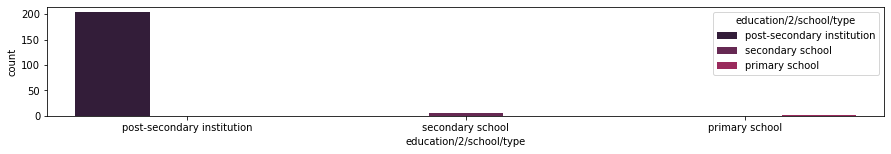

In [521]:
for column in columns_to_visualize:
    plot(cluster_2, column)

Cluster 2 candidates are Head of operations working in Germany with high education.

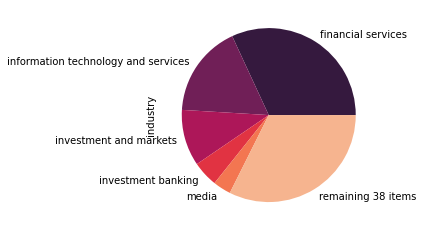

In [522]:
plot_pie_chart_top_5(cluster_2, "industry")

Employees from the cluster 2 work in financial services

## Candidates Similar to the Selected Client

In [523]:
candidate_selected_cluster = X_train["Cluster"][X_train["id"] == candidate_selected_id]
print(candidate_selected_cluster)

0    2
Name: Cluster, dtype: uint16


**Selected candidate data:**

In [524]:
X_train[X_train["id"] == candidate_selected_id]

,id,industry,job_title,job_company_name,job_company_size,job_company_industry,job_company_location_name,job_company_location_region,job_company_location_country,location_name,location_region,location_country,skills/0,skills/1,skills/2,skills/3,skills/4,skills/5,skills/6,skills/7,skills/8,skills/9,skills/10,skills/11,skills/12,skills/13,skills/14,skills/15,skills/16,skills/17,skills/18,skills/19,skills/20,skills/21,skills/22,skills/23,skills/24,location_names/0,location_names/1,regions/0,countries/0,experience/0/company/size,experience/0/company/industry,experience/0/company/location/name,experience/0/company/location/region,experience/0/company/location/country,experience/0/title/name,experience/0/title/role,experience/0/title/levels/0,experience/1/company/size,experience/1/company/industry,experience/1/title/name,experience/1/title/role,experience/2/company/size,experience/2/company/industry,experience/2/company/location/name,experience/2/company/location/region,experience/2/company/location/country,experience/2/title/name,experience/2/title/levels/0,experience/3/company/size,experience/3/company/industry,experience/3/company/location/name,experience/3/company/location/region,experience/3/company/location/country,experience/3/title/name,experience/3/title/levels/0,experience/4/company/size,experience/4/company/industry,experience/4/company/location/name,experience/4/company/location/region,experience/4/company/location/country,experience/4/title/name,education/0/school/type,education/0/school/location/name,education/0/school/location/country,education/1/school/type,education/2/school/type,location_names/2,regions/1,experience/1/company/location/name,experience/1/company/location/region,experience/1/company/location/country,experience/1/title/levels/0,experience/5/company/size,experience/5/company/industry,experience/5/company/location/name,experience/5/company/location/country,experience/5/title/name,experience/6/company/size,experience/6/company/industry,experience/6/title/name,education/1/school/location/name,education/1/school/location/country,row_num,Cluster
0,WZKVV2ikfnr1V7SjDBW0iA_0000,accounting,vice president,hdfc life,10001+,insurance,"bombay, maharashtra, india",maharashtra,india,"mumbai, maharashtra, india",maharashtra,india,auditing,financial reporting,ifrs,internal controls,external audit,financial accounting,assurance,internal audit,statutory audit,accounting,tax,big 4,statutory accounting,financial analysis,finance,us gaap,income tax,consolidation,management,international financial reporting standards,international tax,corporate tax,insurance,team building,public speaking,"bombay, maharashtra, india","mumbai, maharashtra, india","maharashtra, india",india,10001+,insurance,"bombay, maharashtra, india",maharashtra,india,vice president,sales,vp,10001+,information technology and services,trainee,sales,10001+,management consulting,"new york, new york, united states",new york,united states,director,director,10001+,management consulting,"london, england, united kingdom",england,united kingdom,senior audit manager,manager,10001+,management consulting,"new york, new york, united states",new york,united states,senior manager,post-secondary institution,india,india,post-secondary institution,post-secondary institution,"london, greater london, united kingdom","greater london, united kingdom","new york, new york, united states",new york,united states,manager,10001+,information technology and services,"new york, new york, united states",united states,chief executive officer,10001+,information technology and services,chief marketing officer,united kingdom,united states,0,2


In [525]:
print("Candidates similar to the selected candidate (Id): ")
similar_candidates = pd.DataFrame(X_train[(X_train["Cluster"].isin(candidate_selected_cluster)) & (X_train["id"] != candidate_selected_id)]["id"])
similar_candidates

Candidates similar to the selected candidate (Id): 


,id
1,BSfKKSKE8bsGg69Iii5JKA_0000
2,xhQMJHGleF1L0bUw7KL1rA_0000
3,6221rMpU2-ikeUKAsEqq7w_0000
4,Kv2oFYjKg9i-kBajFxgPpA_0000
5,1wbR7z-MybLXRwtTsy2K-g_0000
...,...
43,mHBNNgY8r7yzRCO5UeXNIg_0000
48,TB0TkZbw90OdcaqtT-9Y3g_0000
56,78mi1E6q9WWkmLqIFhM-ng_0000
59,BO60P8YBMgk-AfijLVTBOA_0000


# Cluster Evaluation
****

Dissimilarity measure:

**d(i, j) = 1/(1 + euclidean(i,j))

* p is the number of classes/categories in your data **Q: WHAT IS THIS IN OUT DATA? A: COLUMNS**
* m is the number of matches you have between samples i and j **number of columns with a match**

So, in order to measure the dissimilarity within a cluster we calculate pairwise dissimilarity between each object in every cluster and then take the average of that.

In [190]:
dataset = cluster_0 # encoded X_train

le = preprocessing.LabelEncoder()
dataset = dataset.apply(le.fit_transform)

Our euclidean distance function can be defined as follows:

√‾∑(xi−yi)2

In [198]:
from scipy.spatial.distance import euclidean, pdist, squareform

def similarity_func(u, v):
    return 1/(1 + euclidean(u,v))

def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

dists = pdist(dataset, similarity_func)
DF_euclid = pd.DataFrame(squareform(dists), columns = dataset.index, index = dataset.index)

dists_2 = pdist(dataset, euclidean_distance)
DF_euclid_2 = pd.DataFrame(squareform(dists_2), columns = dataset.index, index = dataset.index)

In [207]:
DF_euclid.max().head(10)

0     0.002330
2     0.001970
3     0.002315
4     0.002259
5     0.002090
6     0.002156
7     0.002195
8     0.002426
9     0.002121
10    0.002431
dtype: float64

In [208]:
DF_euclid

,0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,5,8,11,25,27,31,40,47,50,51,59,62,64,68,70,71,77,80,81,87,89,90,92,95,99,5,10,17,22,23,26,27,32,38,43,46,63,73,75,76,85,93,0,1,2,3,4,5,6,7,8,9,0,6,14,16,20,23,34,38,42,46,47,48,54,56,58,59,60,67,72,74,79,82,83,86
0,0.000000,0.001558,0.002065,0.002103,0.001643,0.001752,0.001681,0.001754,0.001857,0.002007,0.001789,0.002193,0.001723,0.001790,0.001853,0.001755,0.001885,0.001923,0.001524,0.001889,0.001983,0.001854,0.001619,0.001672,0.002221,0.001712,0.002330,0.001912,0.001659,0.001862,0.001575,0.001854,0.001782,0.001673,0.001898,0.001665,0.001833,0.001713,0.001973,0.001694,0.001684,0.001805,0.001669,0.001764,0.001676,0.001802,0.001967,0.001858,0.001625,0.001718,0.001878,0.001809,0.001903,0.002052,0.001823,0.001607,0.001777,0.001655,0.001919,0.001590,0.001820,0.001841,0.001831,0.001889,0.002043,0.001846,0.001936,0.001404,0.001544,0.001471,0.001986,0.001570,0.001851,0.001551,0.001810,0.001770,0.001590,0.001759,0.001705,0.001630,0.001986,0.001802,0.001576,0.002064,0.001869,0.001478,0.001942,0.001657,0.001764,0.001678,0.001649,0.001813,0.001712,0.002146,0.001815,0.001855,0.002110,0.001977,0.001880,0.002040,0.001592,0.001948,0.001877,0.001751,0.001977,0.001750,0.001664,0.001989,0.001721,0.001782,0.001968,0.001790,0.001666,0.001801,0.001661,0.001870,0.001766,0.001898,0.001987,0.001733,0.001693,0.001742,0.001657,0.001840,0.001836,0.001990,0.002008,0.001761,0.001834,0.001936,0.001656,0.001920,0.001945,0.001632,0.002127,0.002009,0.001913,0.001581,0.001968,0.001676,0.001801,0.001846,0.001728,0.001862,0.001844,0.001583,0.001650,0.001778,0.002004,0.001940,0.001575,0.001775,0.001903,0.001818,0.001653,0.002075,0.002100,0.001722,0.001896,0.002023,0.001890,0.001571,0.001934,0.001677,0.001748,0.001469,0.001453,0.001706,0.001634,0.001880,0.001526,0.001784,0.001772,0.001859,0.002041,0.001512,0.001689,0.001782,0.001943,0.001737,0.001768,0.001870,0.001961,0.001723,0.001906,0.002054,0.001928,0.002028,0.001820,0.001702,0.001759,0.001970,0.001795,0.001633,0.001667,0.001805,0.001721,0.001626,0.001577,0.001723,0.001493,0.001622,0.001486,0.001637,0.001490,0.001662,0.001542,0.001760,0.001616,0.001655,0.001585,0.001598,0.001652,0.001582,0.001611,0.001472,0.001619,0.001773,0.001815,0.001716,0.001559,0.001656,0.001501,0.001676,0.001548,0.001579,0.001369,0.001676,0.001531,0.001667,0.001675,0.001434,0.001815,0.001618,0.001639,0.001635,0.001456,0.001524,0.001803,0.001608,0.001545,0.001458,0.001615,0.001584,0.001468,0.001637,0.001690,0.001721,0.001679,0.001702,0.001503,0.001562,0.001810,0.001535,0.001610,0.001623,0.001750,0.001528,0.001538,0.001475,0.001599,0.001434,0.001464,0.001564,0.001518,0.001778,0.001446,0.001684,0.001530,0.001438,0.001462,0.001700,0.001415,0.001482,0.001559,0.001801,0.001388,0.001404,0.001413,0.001531,0.001715,0.001536,0.001476,0.001609,0.001444,0.001530,0.001464,0.001610,0.001541,0.001488,0.001492,0.001609,0.001718,0.001552,0.001603,0.001751,0.001634,0.001362,0.001624,0.001632,0.001650,0.001543,0.001693,0.001406,0.001463,0.001694,0.001472,0.001512,0.001527,0.001606,0.001498,0.001659,0.001696,0.001508,0.001480,0.001578,0.001594,0.001619,0.001606,0.001488,0.001527,0.001499,0.001613,0.001486,0.001479,

In [204]:
DF_euclid_2.max().head(10)

0     772.792340
2     823.014581
3     784.180464
4     740.313447
5     805.758649
6     820.962240
7     808.713794
8     766.368710
9     791.895195
10    754.752277
dtype: float64

# Conclusion
****

LightGBM model showed the best results when testing on the validation_set, with 39.7%. Next, we will change the hyperparameters to get the best values and to lower the WMAPE measure of error: